## Computer Vision (EECE 7219) Assignment #4
### University of Memphis, Spring 2023
#### Instructor: Dr. Yeasin

Bereket Kebede, Gradaute Student, EECE

## EigenFace Recognition Algorithm

1. Download the yale database containing face images.

2. Use this database to implement the EigenFace Recognition algorithm.

3. Use precision, recall, and F1-score to evaluate your model. For testing performance on non-face images, use cifar-10 dataset.

In [14]:
from os import listdir
import numpy as np
import matplotlib.pyplot as plt
from numpy import asarray

# load images and extract faces for a given subject - updated version from the last model
def load_faces2(subject):
    faces = list()
    folder = "C:/Users/Berek/Documents\Graduate School\Spring 2023\Computer Vision\Assignment 4/yale/"
    # enumerate files
    for filename in listdir(folder):
        if filename.split(".")[0] == 'subject' + subject:
            # path
            path = folder + filename
            # get face
            face = plt.imread(path)
            # store
            faces.append(face)
    return faces

In [15]:
def load_dataset2():
    subjects = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15']
    X_train, y_train, X_test, y_test = list(), list(), list(), list()
    count = 0
    
    for subject in subjects:
        faces = load_faces2(subject)
        labels = [subject for _ in range(len(faces))]
         # summarize progress
        print('>loaded %d examples for class: %s' % (len(faces), subject))
        # store

        X_train.extend(faces[:8])
        y_train.extend(labels[:8])
        
        X_test.extend(faces[8:])
        y_test.extend(labels[8:])

            
            
    return asarray(X_train), asarray(y_train), asarray(X_test), asarray(y_test)

In [17]:
trainX1, trainy, testX1, testy = load_dataset2()

>loaded 11 examples for class: 01
>loaded 11 examples for class: 02
>loaded 11 examples for class: 03
>loaded 11 examples for class: 04
>loaded 11 examples for class: 05
>loaded 11 examples for class: 06
>loaded 11 examples for class: 07
>loaded 11 examples for class: 08
>loaded 11 examples for class: 09
>loaded 11 examples for class: 10
>loaded 11 examples for class: 11
>loaded 11 examples for class: 12
>loaded 11 examples for class: 13
>loaded 11 examples for class: 14
>loaded 11 examples for class: 15


In [37]:
trainX1.shape

(120, 243, 320)

In [18]:
# Reshaping images for machine learning model
trainX = trainX1.reshape((trainX1.shape[0],trainX1.shape[1]*trainX1.shape[2]))
print("New trainX shape:",trainX.shape)

testX = testX1.reshape((testX1.shape[0],testX1.shape[1]*testX1.shape[2]))
print("New testX shape:",testX.shape)

New trainX shape: (120, 77760)
New testX shape: (45, 77760)


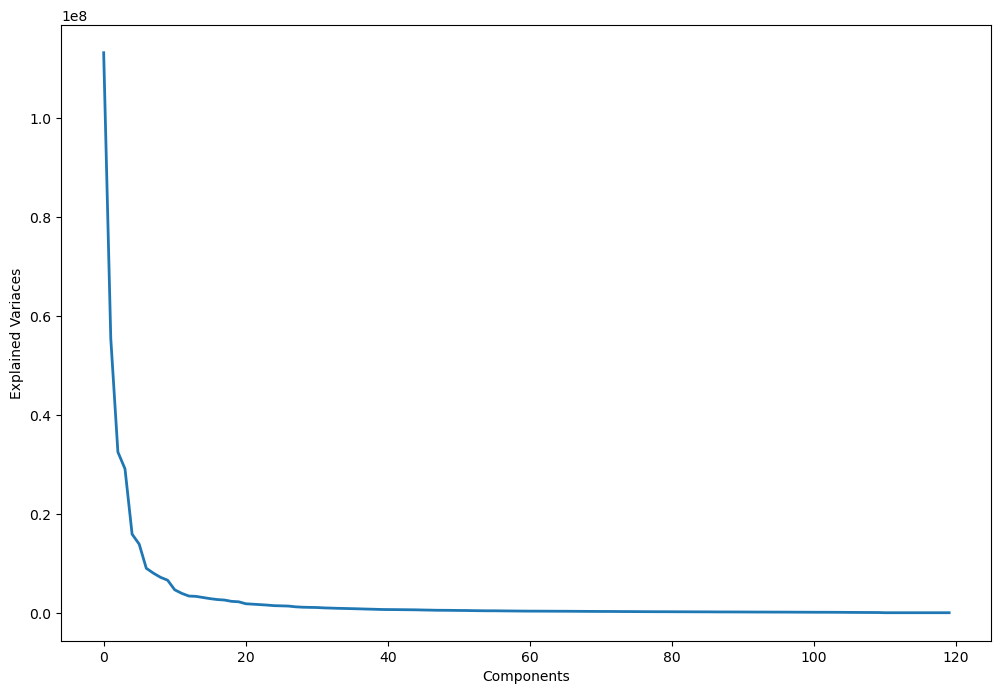

In [19]:
# plotting a graph to see what the best value is for n_components

from sklearn.decomposition import PCA
pca=PCA()
pca.fit(trainX)

plt.figure(1, figsize=(12,8))

plt.plot(pca.explained_variance_, linewidth=2)
 
plt.xlabel('Components')
plt.ylabel('Explained Variaces')
plt.show()

In [20]:
# from the above diagram it can be seen that at around 40, the pca compenents represent the same data
from sklearn.decomposition import PCA
pca=PCA(n_components=40, whiten=True)
pca.fit(trainX)

PCA(n_components=40, whiten=True)

Text(0.5, 1.0, 'Average Face')

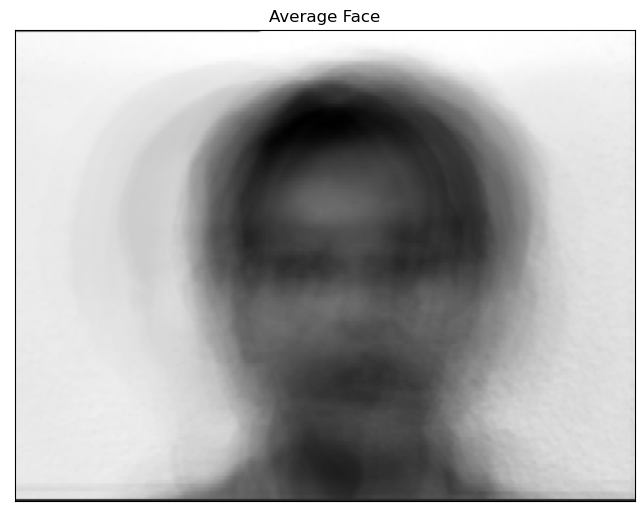

In [21]:
# the average face of the dataset

fig,ax=plt.subplots(1,1,figsize=(8,8))
ax.imshow(pca.mean_.reshape((243,320)), cmap="gray")
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Average Face')

Text(0.5, 0.98, 'All Eigen Faces')

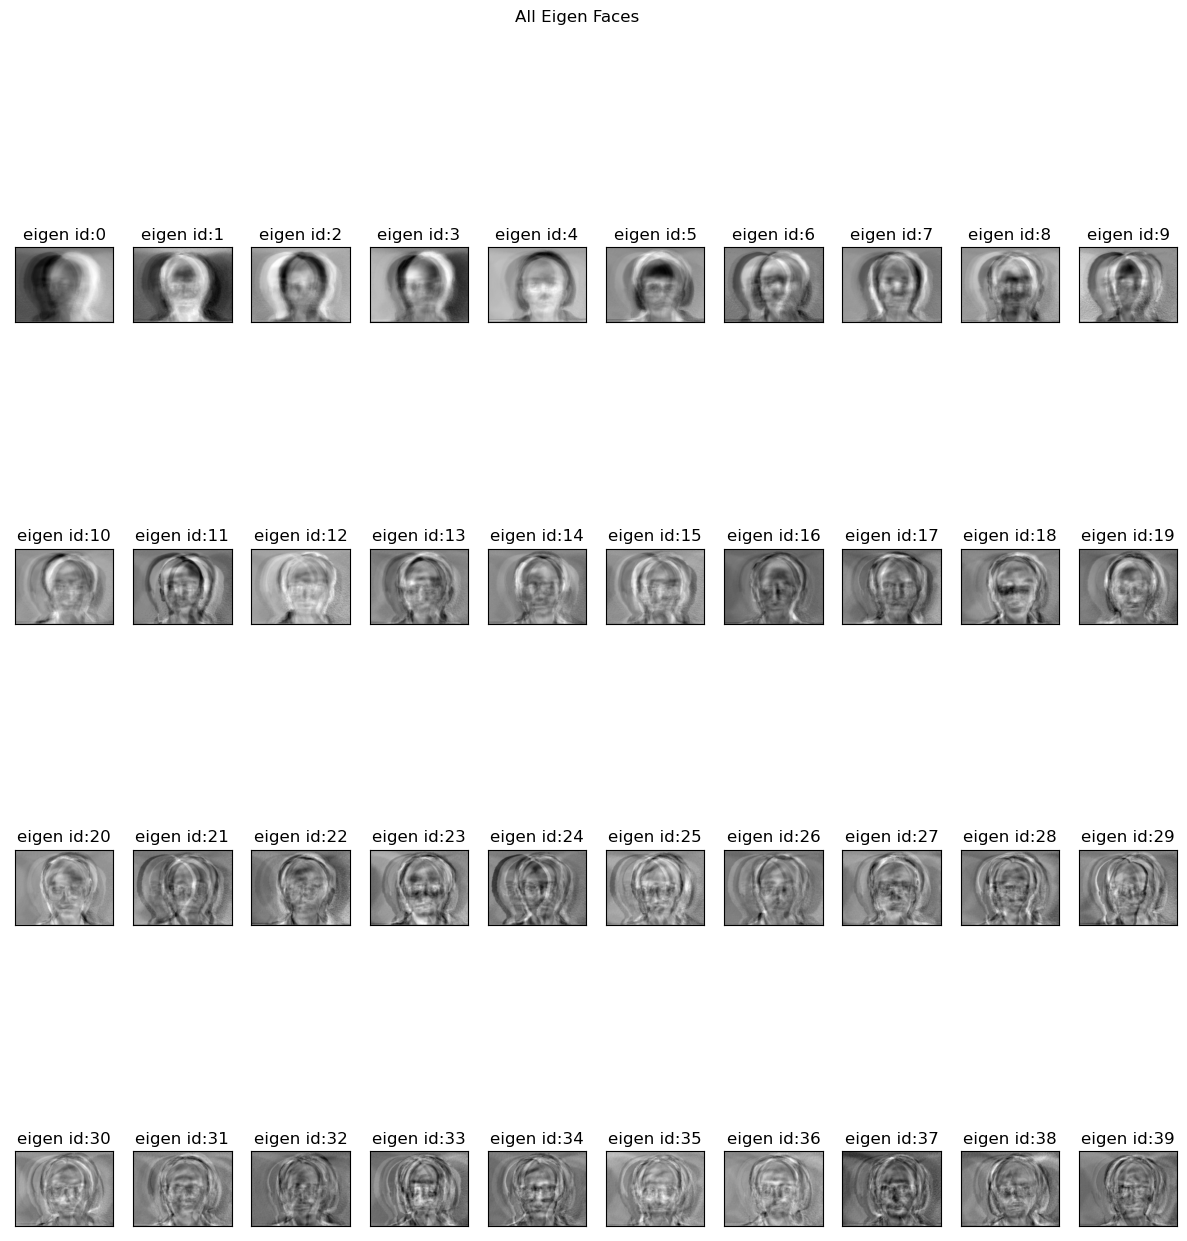

In [22]:
# pictures of some of the faces after encoding

number_of_eigenfaces=len(pca.components_)
eigen_faces=pca.components_.reshape((number_of_eigenfaces, trainX1.shape[1], trainX1.shape[2]))

cols=10
rows=int(number_of_eigenfaces/cols)
fig, axarr=plt.subplots(nrows=rows, ncols=cols, figsize=(15,15))
axarr=axarr.flatten()
for i in range(number_of_eigenfaces):
    axarr[i].imshow(eigen_faces[i],cmap="gray")
    axarr[i].set_xticks([])
    axarr[i].set_yticks([])
    axarr[i].set_title("eigen id:{}".format(i))
plt.suptitle("All Eigen Faces".format(10*"=", 10*"="))

In [23]:
X_train_pca=pca.transform(trainX)
X_test_pca=pca.transform(testX)

In [25]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier

KNN = KNeighborsClassifier(n_neighbors=1)
KNN.fit(X_train_pca, trainy)
y_pred = KNN.predict(X_test_pca)
print("accuracy score:{:.2f}".format(accuracy_score(testy, y_pred)))
print("Classification Results:\n{}".format(classification_report(testy, y_pred)))

accuracy score:0.96
Classification Results:
              precision    recall  f1-score   support

          01       1.00      1.00      1.00         3
          02       1.00      1.00      1.00         3
          03       1.00      1.00      1.00         3
          04       1.00      1.00      1.00         3
          05       1.00      1.00      1.00         3
          06       1.00      1.00      1.00         3
          07       0.75      1.00      0.86         3
          08       1.00      0.33      0.50         3
          09       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         3
          12       1.00      1.00      1.00         3
          13       0.75      1.00      0.86         3
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00         3

    accuracy                           0.96        45
   macro avg       0.97      0.96   

C:\Users\Berek\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [31]:
X_test_pca.shape

(45, 40)

## Test on CIFAR

In [28]:
import tensorflow as tf
import pandas as pd 

In [52]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [53]:
# Reduce pixel values
x_train, x_test = x_train / 255.0, x_test / 255.0
 
# # flatten the label values
# y_train, y_test = y_train.flatten(), y_test.flatten()

In [54]:
x_test.shape

(10000, 32, 32, 3)

In [55]:
x_test_new = x_test[:,:,:,0].reshape((x_test.shape[0],x_test.shape[1]*x_test.shape[2]))
print("x_test_new shape:",x_test_new.shape)

x_test_new shape: (10000, 1024)


In [56]:
pca_cifar=PCA(n_components=40, whiten=True)
pca_cifar.fit(x_test_new)

PCA(n_components=40, whiten=True)

In [57]:
y_test.shape

(10000, 1)

In [58]:
x_test_cifar_pca = pca_cifar.transform(x_test_new)

In [80]:
y_pred_cifar = KNN.predict(x_test_cifar_pca)
print("accuracy score:{:.2f}".format(accuracy_score(y_test, pd.to_numeric(y_pred_cifar))))
print("Classification Results:\n{}".format(classification_report(y_test, pd.to_numeric(y_pred_cifar))))

C:\Users\Berek\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


accuracy score:0.07
Classification Results:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1000
           1       0.09      0.06      0.07      1000
           2       0.09      0.08      0.09      1000
           3       0.10      0.06      0.08      1000
           4       0.08      0.05      0.06      1000
           5       0.08      0.21      0.11      1000
           6       0.09      0.03      0.05      1000
           7       0.11      0.11      0.11      1000
           8       0.09      0.02      0.03      1000
           9       0.12      0.05      0.07      1000
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0

    accuracy                        

C:\Users\Berek\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Berek\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Berek\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Berek\anaconda3\lib\site-packages\sklearn\metrics\_cla